# Walmart : predict weekly sales

Walmart's marketing service need a machine learning model able to estimate the weekly sales in their stores, with the best precision possible on the predictions made. Such a model would help them understand better how the sales are influenced by economic indicators, and might be used to plan future marketing campaigns.

## Part 1 : EDA

In [1]:
# Import useful libraries

import pandas as pd
import numpy as np; np.random.seed(42)
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
!pip install plotly -q
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "iframe_connected"


In [2]:
# Read the file

print("Loading dataset...")
df = pd.read_csv("Walmart_Store_sales.csv")
print("...Done.")
print()
df.head()

Loading dataset...
...Done.



,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


In [3]:
# Basics statistics

print("Number of rows : {}".format(df.shape[0]))
print()

print("Number of columns : {}".format(df.shape[1]))
print()

print("Basics statistics: ")
df_desc = df.describe(include='all')
display(df_desc)
print()

print("Percentage of missing values: ")
print()
display(100*df.isnull().sum()/df.shape[0])

Number of rows : 150

Number of columns : 8

Basics statistics: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,07-01-2011,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



Percentage of missing values: 



Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

In [4]:
# Drop lines where target values are missing

print("Dropping lines...")
df = df[df["Weekly_Sales"].notna()]
print("...Done.")
print()
df.head()

Dropping lines...
...Done.



,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
5,4.0,28-05-2010,1857533.70,0.0,NaN,2.756,126.160226,7.896


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Weekly Sales Distribution')

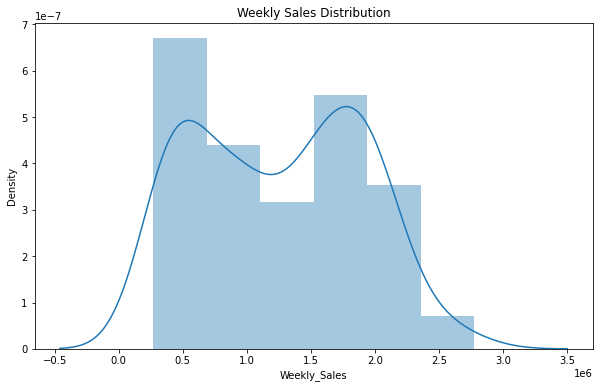

In [5]:
# Target distribution

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(df['Weekly_Sales'])
plt.title('Weekly Sales Distribution')

In [6]:
#Creation of new columns from the 'Date' column for data processing

df['Date']= pd.to_datetime(df['Date']) 

print("Creating column 'Year'...")
df['Year'] = df['Date'].dt.year
print("...Done.")
print()

print("Creating column 'Month'...")
df['Month'] = df['Date'].dt.month
print("...Done.")
print()

print("Creating column 'Day'...")
df['Day'] = df['Date'].dt.day
print("...Done.")
print()

print("Creating column 'DayOfWeek'...")
df['DayOfWeek'] = df['Date'].dt.weekday
print("...Done.")
print()

print("Dropping column 'Date'...")
df = df.drop(columns=["Date"])
print("...Done.")
print()

df.head()

Creating column 'Year'...
...Done.

Creating column 'Month'...
...Done.

Creating column 'Day'...
...Done.

Creating column 'DayOfWeek'...
...Done.

Dropping column 'Date'...
...Done.



,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,DayOfWeek
0,6.0,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011.0,2.0,18.0,4.0
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011.0,3.0,25.0,4.0
3,11.0,1244390.03,0.0,84.57,NaN,214.556497,7.346,NaN,NaN,NaN,NaN
4,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010.0,5.0,28.0,4.0
5,4.0,1857533.70,0.0,NaN,2.756,126.160226,7.896,2010.0,5.0,28.0,4.0


Text(0.5, 1.0, 'Distribution of numerical variables')

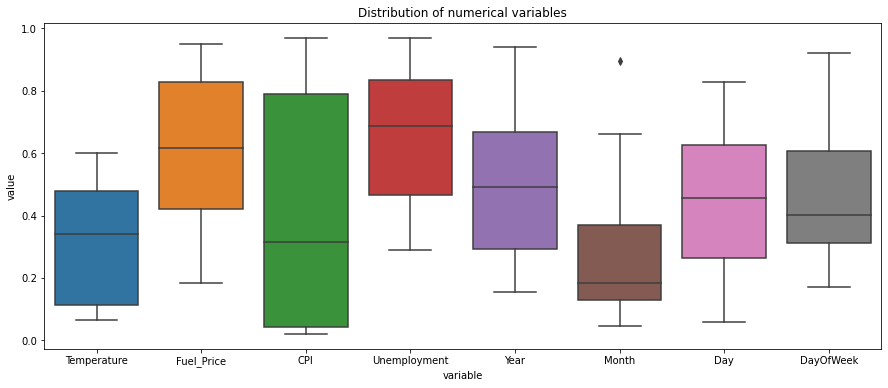

In [7]:
# Numerical variables distribution

dataset = pd.DataFrame(data = np.random.random(size=(8,8)), columns = ['Temperature','Fuel_Price','CPI','Unemployment','Year','Month','Day','DayOfWeek'])
fig, ax = plt.subplots(figsize=(15,6))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(dataset))
plt.title('Distribution of numerical variables')

In [8]:
# Drop lines containing outliers (using masks)
# In this project, will be considered as outliers all the numeric features that don't fall within the range : [𝑋¯−3𝜎,𝑋¯+3𝜎]. This concerns the columns : Temperature, Fuel_price, CPI and Unemployment

print('Dropping outliers in Temperature...')
to_keep = (df["Temperature"] >= df["Temperature"].mean() - 3*df["Temperature"].std()) & (df["Temperature"] <= df["Temperature"].mean() + 3*df["Temperature"].std())
df = df.loc[to_keep,:]
print('Done. Number of lines remaining : ', df.shape[0])
print()

print('Dropping outliers in Fuel_Price...')
to_keep = (df["Fuel_Price"] >= df["Fuel_Price"].mean() - 3*df["Fuel_Price"].std()) & (df["Fuel_Price"] < df["Fuel_Price"].mean() + 3*df["Fuel_Price"].std())
df = df.loc[to_keep,:]
print('Done. Number of lines remaining : ', df.shape[0])
print()

print('Dropping outliers in CPI...')
to_keep = (df["CPI"] >= df["CPI"].mean() - 3*df["CPI"].std()) & (df["CPI"] < df["CPI"].mean() + 3*df["CPI"].std()) 
df = df.loc[to_keep,:]
print('Done. Number of lines remaining : ', df.shape[0])
print()

print('Dropping outliers in Unemployment...')
to_keep = (df["Unemployment"] >= df["Unemployment"].mean() - 3*df["Unemployment"].std()) & (df["Unemployment"] < df["Unemployment"].mean() + 3*df["Unemployment"].std())
df = df.loc[to_keep,:]
print('Done. Number of lines remaining : ', df.shape[0])
print()

print("Dataset shape: ")
display(df.shape)
print()

print("Percentage of missing values: ")
print()
display(100*df.isnull().sum()/df.shape[0])

Dropping outliers in Temperature...
Done. Number of lines remaining :  121

Dropping outliers in Fuel_Price...
Done. Number of lines remaining :  109

Dropping outliers in CPI...
Done. Number of lines remaining :  102

Dropping outliers in Unemployment...
Done. Number of lines remaining :  90

Dataset shape: 


(90, 11)


Percentage of missing values: 



Store            0.000000
Weekly_Sales     0.000000
Holiday_Flag    11.111111
Temperature      0.000000
Fuel_Price       0.000000
CPI              0.000000
Unemployment     0.000000
Year            11.111111
Month           11.111111
Day             11.111111
DayOfWeek       11.111111
dtype: float64

In [9]:
# Distribution of each quantitative variable

num_features = ["Temperature", "Fuel_Price", "CPI", "Unemployment", "Year", "Month", "Day", "DayOfWeek"]
fig1 = make_subplots(rows = len(num_features), cols = 1, subplot_titles = num_features)
for i in range(len(num_features)):
    fig1.add_trace(
        go.Histogram(
            x = df[num_features[i]], nbinsx = 30),
        row = i + 1,
        col = 1)
fig1.update_layout(
        title = go.layout.Title(text = "Distribution of quantitative variables", x = 0.5), showlegend = False, 
            autosize=True, height=2000)
fig1.show()

In [10]:
# Barplot of each qualitative variable

cat_features = ["Store", "Holiday_Flag"]
fig2 = make_subplots(rows = len(cat_features), cols = 1, subplot_titles = cat_features)
for i in range(len(cat_features)):
    
    x_coords = df[cat_features[i]].value_counts().index.tolist()
    y_coords = df[cat_features[i]].value_counts().tolist()
    
    fig2.add_trace(
        go.Bar(
            x = x_coords,
            y = y_coords),
        row = i + 1,
        col = 1)
fig2.update_layout(
        title = go.layout.Title(text = "Barplot of qualitative variables", x = 0.5), showlegend = False, 
            autosize=False, height=500)
fig2.show()

In [11]:
# Correlation matrix

corr= df.corr()
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def matrix():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Correlation matrix")\
    .set_precision(2)\
    .set_table_styles(matrix())

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,DayOfWeek
Store,1.00,0.14,-0.06,-0.32,0.20,-0.57,0.29,0.02,-0.24,0.06,-0.05
Weekly_Sales,0.14,1.00,0.00,-0.09,-0.02,-0.37,0.09,-0.05,-0.07,-0.04,0.14
Holiday_Flag,-0.06,0.00,1.00,-0.31,-0.23,0.21,0.06,-0.09,0.36,-0.13,-0.24
Temperature,-0.32,-0.09,-0.31,1.00,-0.04,0.16,-0.20,-0.16,0.01,0.16,0.19
Fuel_Price,0.20,-0.02,-0.23,-0.04,1.00,-0.21,-0.03,0.85,-0.24,0.05,0.02
CPI,-0.57,-0.37,0.21,0.16,-0.21,1.00,-0.21,-0.07,0.21,0.13,0.01
Unemployment,0.29,0.09,0.06,-0.20,-0.03,-0.21,1.00,-0.13,-0.20,-0.07,-0.02
Year,0.02,-0.05,-0.09,-0.16,0.85,-0.07,-0.13,1.00,-0.18,-0.07,-0.13
Month,-0.24,-0.07,0.36,0.01,-0.24,0.21,-0.20,-0.18,1.00,-0.06,-0.39
Day,0.06,-0.04,-0.13,0.16,0.05,0.13,-0.07,-0.07,-0.06,1.00,0.24


## Part 2 : Data preprocessing and Baseline model (linear regression)

In [12]:
# Separate target variable Y from features X

target_name = "Weekly_Sales"

print("Separating labels from features...")
Y = df.loc[:,target_name]
X = df.loc[:,[c for c in df.columns if c!=target_name]]
print("...Done.")
print()
print(Y.head())
print()
print(X.head())
print()

Separating labels from features...
...Done.

0    1572117.54
1    1807545.43
4    1644470.66
6     695396.19
7    2203523.20
Name: Weekly_Sales, dtype: float64

   Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
0    6.0           NaN        59.61       3.045  214.777523         6.858   
1   13.0           0.0        42.38       3.435  128.616064         7.470   
4    6.0           0.0        78.89       2.759  212.412888         7.092   
6   15.0           0.0        69.80       4.069  134.855161         7.658   
7   20.0           0.0        39.93       3.617  213.023623         6.961   

     Year  Month   Day  DayOfWeek  
0  2011.0    2.0  18.0        4.0  
1  2011.0    3.0  25.0        4.0  
4  2010.0    5.0  28.0        4.0  
6  2011.0    3.0   6.0        6.0  
7  2012.0    3.0   2.0        4.0  



In [13]:
# Divide dataset into train set & test set

print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [14]:
# Create pipeline for numeric features

print("Creating numeric pipeline...")
numeric_features = [2,3,4,5,6,7,8,9] 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())
])
print("... Done")

Creating numeric pipeline...
... Done


In [15]:
# Create pipeline for categorical features

print("Creating categorical pipeline...")
categorical_features = [0,1]
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first'))
    ])
print("... Done")

Creating categorical pipeline...
... Done


In [16]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)  
    ])

In [17]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print()
print(X_train[0:5])
X_train = preprocessor.fit_transform(X_train)
print()
print('...Done.')
print()
print(X_train[0:5])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print()
print(X_test[0:5])
X_test = preprocessor.transform(X_test)
print()
print('...Done.')
print()
print(X_test[0:5])
print()

Performing preprocessings on train set...

     Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
127   16.0           0.0        61.79       2.711  189.523128         6.868   
63     5.0           0.0        69.17       3.594  224.019287         5.422   
35    19.0           0.0        33.26       3.789  133.958742         7.771   
10     8.0           0.0        82.92       3.554  219.070197         6.425   
95     1.0           0.0        74.78       2.854  210.337426         7.808   

       Year  Month   Day  DayOfWeek  
127  2010.0    9.0   7.0        1.0  
63   2012.0   10.0  19.0        4.0  
35   2011.0    3.0  25.0        4.0  
10   2011.0    8.0  19.0        4.0  
95   2010.0    5.0  14.0        4.0  

...Done.

[[ 0.04260362 -1.26840641  0.20507788 -0.55534542 -1.1763434   0.74406169
  -1.10466577 -2.03634567  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        

In [18]:
# Train model

print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [19]:
# Predictions on training set

print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train)
print("...Done.")
print()
print(Y_train_pred)
print()

Predictions on training set...
...Done.

[ 644739.87631778  355961.21302242 1283683.95825666  873600.72085917
 1545674.18777559 1519305.5002929  1966321.18728955  632253.48931953
  934665.25778376 1106203.81892398 2109844.24900673  620394.29367058
 2116108.88885293  579361.51152776  523650.68223199  829840.2763789
  620835.07700988 1625192.11687657  177256.13336628  579884.50288008
 1874144.32532234 2127216.04569167 1157590.70567369 1456023.61818636
 2048596.03696647 1964682.15755974  431904.87899836 2025325.23874351
  941488.51688632 1606274.11544423 1996738.76154149 1607913.18161494
 1547449.80174053 1893961.39974091  324759.72422195  473917.01892514
  843309.66220243 1475680.28817667 2029166.07752652 2088426.55333551
  520491.86024224 1964435.55649453 1547638.4291353   409100.24680999
  264377.30378704  500019.18512239  404910.64368222 1785023.25974623
 1995409.45187746  403943.18538385 2080212.25443023 1811182.35909536
  833674.43141868 1555832.71281525  464484.79819478  393742.379

In [20]:
# Predictions on test set

print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test)
print("...Done.")
print()
print(Y_test_pred[0:5])
print()

Predictions on test set...
...Done.

[1575714.86430851  698307.09053609 1977352.5826447  1779803.95325088
  386351.11477159]



In [21]:
# R2 scores

print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.9872729747897621
R2 score on test set :  0.9191907752940758


In [22]:
model_evaluation = pd.DataFrame({"Actual" : Y_test, "Predicted" : Y_test_pred})
model_evaluation.head()

,Actual,Predicted
4,1644470.66,1.575715e+06
20,561145.14,6.983071e+05
82,1569607.94,1.977353e+06
61,1990371.02,1.779804e+06
104,419497.95,3.863511e+05


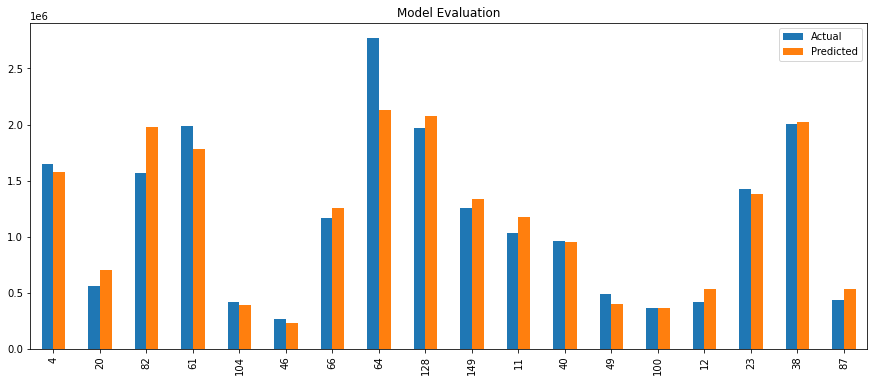

In [23]:
# Visualisation of model evaluation
model_evaluation.plot(kind = 'bar', figsize=(15, 6))
plt.title("Model Evaluation")
plt.show()

## Part 3 : Feature importance ranking

In [24]:
regressor.coef_

array([-1.54652237e+03, -4.95535198e+04,  8.95505770e+05,  3.44490165e+04,
       -3.41753612e+04,  6.61667573e+03, -5.02247508e+04, -1.98919267e+04,
        2.70725103e+05, -1.26975244e+06,  2.60465883e+06, -1.22723018e+06,
        8.97407137e+04, -5.04693067e+05, -6.77059766e+05, -1.13381840e+06,
        2.21117929e+06,  2.75337740e+05,  2.49206740e+06,  1.15215695e+06,
        9.72610528e+05, -5.00150955e+05,  1.28085398e+06,  1.35171050e+06,
        1.71288526e+06,  6.44886032e+05, -1.11664259e+05])

In [25]:
ohe_columns_names = preprocessor.transformers_[1][1][1].get_feature_names()
ohe_columns_names

array(['x0_2.0', 'x0_3.0', 'x0_4.0', 'x0_5.0', 'x0_6.0', 'x0_7.0',
       'x0_8.0', 'x0_9.0', 'x0_10.0', 'x0_11.0', 'x0_13.0', 'x0_14.0',
       'x0_15.0', 'x0_16.0', 'x0_17.0', 'x0_18.0', 'x0_19.0', 'x0_20.0',
       'x1_1.0'], dtype=object)

In [26]:
# Visualize the coefficients of model and deduce a feature importance ranking

# Access transformers from preprocessor
print("All transformers are: ", preprocessor.transformers_)
print()

# Access one specific transformer
print("One Hot Encoder transformer is: ", preprocessor.transformers_[1][1][1])
print()

# Print categories
categorical_column_names = preprocessor.transformers_[1][1][1].get_feature_names()
print("Categorical columns are: ", categorical_column_names)
print()
numerical_column_names = X.iloc[:, numeric_features].columns 
print("numerical columns are: ", numerical_column_names)
print()

# Append all columns 
all_column_names = np.append(numerical_column_names,categorical_column_names)
print("All columns name are: ", all_column_names)

All transformers are:  [('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())]), [2, 3, 4, 5, 6, 7, 8, 9]), ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(drop='first'))]), [0, 1])]

One Hot Encoder transformer is:  OneHotEncoder(drop='first')

Categorical columns are:  ['x0_2.0' 'x0_3.0' 'x0_4.0' 'x0_5.0' 'x0_6.0' 'x0_7.0' 'x0_8.0' 'x0_9.0'
 'x0_10.0' 'x0_11.0' 'x0_13.0' 'x0_14.0' 'x0_15.0' 'x0_16.0' 'x0_17.0'
 'x0_18.0' 'x0_19.0' 'x0_20.0' 'x1_1.0']

numerical columns are:  Index(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month',
       'Day', 'DayOfWeek'],
      dtype='object')

All columns name are:  ['Temperature' 'Fuel_Price' 'CPI' 'Unemployment' 'Year' 'Month' 'Day'
 'DayOfWeek' 'x0_2.0' 'x0_3.0' 'x0_4.0' 'x0_5.0' 'x0_6.0' 'x0_7.0'
 'x0_8.0' 'x0_9.0' 'x0_10.0' 'x0_11.0' 'x0_13.0' 'x0_14.0' 'x0_15.0'
 'x0_16.0' 'x0_17.0' 'x0_18.

In [27]:
# Feature importance 
feature_importance = pd.DataFrame({
    "feature_names": all_column_names,
    "coefficients":regressor.coef_
})
feature_importance.sort_values(by="coefficients", ascending=False)

,feature_names,coefficients
10,x0_4.0,2.604659e+06
18,x0_13.0,2.492067e+06
16,x0_10.0,2.211179e+06
24,x0_19.0,1.712885e+06
23,x0_18.0,1.351710e+06
22,x0_17.0,1.280854e+06
19,x0_14.0,1.152157e+06
20,x0_15.0,9.726105e+05
2,CPI,8.955058e+05
25,x0_20.0,6.448860e+05


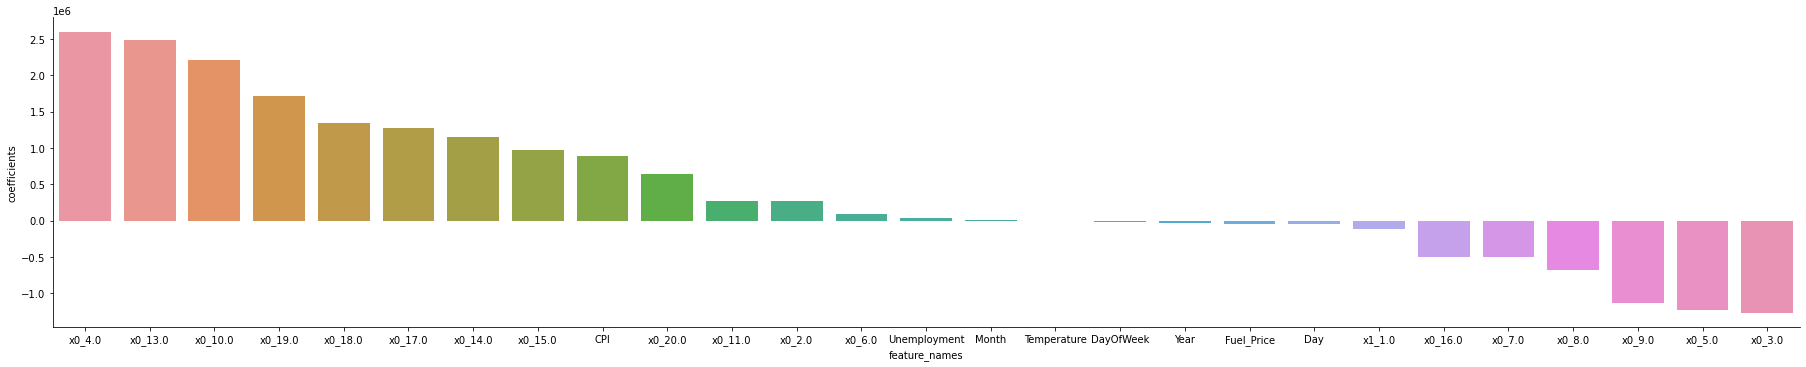

In [28]:
# Visualize ranked features 
sns.catplot(x="feature_names", 
            y="coefficients", 
            data=feature_importance.sort_values(by="coefficients", ascending=False), 
            kind="bar",
            aspect=50/10) 

## Part 4 : Fight overfitting

### Regularized linear regression : RIDGE

In [29]:
# Separate target variable Y from features X

target_name2 = "Weekly_Sales"

print("Separating labels from features...")
Y2 = df.loc[:,target_name2]
X2 = df.loc[:,[c for c in df.columns if c!=target_name2]]
print("...Done.")
print()
print(Y2.head())
print()
print(X2.head())
print()

Separating labels from features...
...Done.

0    1572117.54
1    1807545.43
4    1644470.66
6     695396.19
7    2203523.20
Name: Weekly_Sales, dtype: float64

   Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
0    6.0           NaN        59.61       3.045  214.777523         6.858   
1   13.0           0.0        42.38       3.435  128.616064         7.470   
4    6.0           0.0        78.89       2.759  212.412888         7.092   
6   15.0           0.0        69.80       4.069  134.855161         7.658   
7   20.0           0.0        39.93       3.617  213.023623         6.961   

     Year  Month   Day  DayOfWeek  
0  2011.0    2.0  18.0        4.0  
1  2011.0    3.0  25.0        4.0  
4  2010.0    5.0  28.0        4.0  
6  2011.0    3.0   6.0        6.0  
7  2012.0    3.0   2.0        4.0  



In [30]:
# Divide dataset into train set & test set

print("Dividing into train and test sets...")
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [31]:
# Create pipeline for numeric features

print("Creating numeric pipeline...")
numeric_features2 = [2,3,4,5,6,7,8,9] 
numeric_transformer2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())
])
print("... Done")

Creating numeric pipeline...
... Done


In [32]:
# Create pipeline for categorical features

print("Creating categorical pipeline...")
categorical_features2 = [0,1]
categorical_transformer2 = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first'))
    ])
print("... Done")

Creating categorical pipeline...
... Done


In [33]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done

preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer2, numeric_features2),
        ('cat', categorical_transformer2, categorical_features2)  
    ])

In [34]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print()
print(X_train2[0:5])
X_train2 = preprocessor2.fit_transform(X_train2)
print()
print('...Done.')
print()
print(X_train2[0:5])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print()
print(X_test2[0:5])
X_test2 = preprocessor2.transform(X_test2)
print()
print('...Done.')
print()
print(X_test2[0:5])
print()

Performing preprocessings on train set...

     Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
127   16.0           0.0        61.79       2.711  189.523128         6.868   
63     5.0           0.0        69.17       3.594  224.019287         5.422   
35    19.0           0.0        33.26       3.789  133.958742         7.771   
10     8.0           0.0        82.92       3.554  219.070197         6.425   
95     1.0           0.0        74.78       2.854  210.337426         7.808   

       Year  Month   Day  DayOfWeek  
127  2010.0    9.0   7.0        1.0  
63   2012.0   10.0  19.0        4.0  
35   2011.0    3.0  25.0        4.0  
10   2011.0    8.0  19.0        4.0  
95   2010.0    5.0  14.0        4.0  

...Done.

[[ 0.04260362 -1.26840641  0.20507788 -0.55534542 -1.1763434   0.74406169
  -1.10466577 -2.03634567  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        

In [35]:
#Cross-validated score for a Ridge model (with default value of λ\lambda)

# Perform 3-fold cross-validation to evaluate the generalized R2 score obtained with a Ridge model
print("3-fold cross-validation...")
regressor2 = Ridge()
scores = cross_val_score(regressor, X_train2, Y_train2, cv=3)
print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())


3-fold cross-validation...
The cross-validated R2-score is :  0.43984280821410665
The standard deviation is :  0.5914179324186112


In [36]:
#Grid search : tune λ\lambda

# Perform grid search
print("Grid search...")
regressor2 = Ridge()
# Grid of values to be tested
params = {
    'alpha': [0.0, 0.1, 0.5, 1.0] # 0 corresponds to no regularization
}
gridsearch = GridSearchCV(regressor2, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train2, Y_train2)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)


Grid search...
...Done.
Best hyperparameters :  {'alpha': 0.1}
Best R2 score :  0.8262927909736183


In [37]:
# Predictions on training set
# The model has already be re-trained on all the training set at the end of the grid search, so we can directly use it !
print("Predictions on training set...")
Y_train_pred2 = gridsearch.predict(X_train2)
print("...Done.")
print(Y_train_pred2)
print()


Predictions on training set...
...Done.
[ 671303.09644346  320731.97504248 1292251.4228695   907542.61936534
 1505310.21978721 1475549.39895693 1974926.43996589  639862.43081416
  939103.17386366 1053826.16872528 2105907.76612869  635168.67138788
 2111551.97900147  582383.91344906  548044.19948337  875143.46167042
  669743.98363335 1540462.56667658  264362.42392045  601415.03321856
 1930923.74117682 2109101.50757031 1148375.12641625 1495054.42894667
 2026370.21185677 1959186.99721     371530.88405223 2009237.06001587
  945356.64048989 1613986.76164208 1990709.73052345 1572647.31176242
 1539244.14318231 1876642.09329477  414369.03960002  505346.55762718
  857834.09570405 1442183.42374543 2031634.19238135 1976035.78921829
  530493.17235449 1969609.15572    1537673.57842252  433583.28094341
  315366.67608361  526359.37834724  459998.58438321 1717182.94981958
 2027409.7574412   376851.42786933 2056474.88776213 1851674.51019779
  817294.69214449 1538021.95182836  502026.75975576  396891.097

In [38]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred2 = gridsearch.predict(X_test2)
print("...Done.")
print(Y_test_pred2)
print()


Predictions on test set...
...Done.
[1564911.35562782  671239.55911713 1769950.05970856 1723378.28437101
  415467.7244111   286627.29678861 1210967.13201663 2052213.47801157
 2079445.62150053 1399865.48002623 1151820.92998237  985788.73052878
  455965.08078083  423904.72803311  562705.8861132  1352322.96747913
 2021193.36191896  527390.81225863]



In [39]:
# R2 scores on train/test sets for the Ridge model with optimal value of the regularization strength
print("R2 score on training set : ", r2_score(Y_train2, Y_train_pred2))
print("R2 score on test set : ", r2_score(Y_test2, Y_test_pred2))


R2 score on training set :  0.983418228704619
R2 score on test set :  0.918563909596713


In [40]:
model_evaluation2 = pd.DataFrame({"Actual" : Y_test2, "Predicted" : Y_test_pred2})
model_evaluation2.head()

,Actual,Predicted
4,1644470.66,1.564911e+06
20,561145.14,6.712396e+05
82,1569607.94,1.769950e+06
61,1990371.02,1.723378e+06
104,419497.95,4.154677e+05


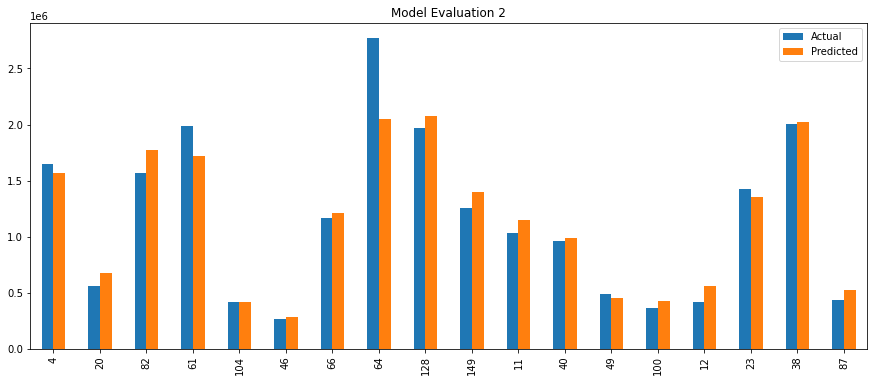

In [41]:
# Visualisation of model evaluation
model_evaluation2.plot(kind = 'bar', figsize=(15, 6))
plt.title("Model Evaluation 2")
plt.show()

## Part 4 : Conclusion

The models tested (linear regression and regularized linear regression) give equivalent results with an R2 score of 98% on the training set and 92% on the test set.

It would seem from these models that economic indicators do not influence sales but that the most important factor is the store itself, probably its geographical position but this needs to be studied to be confirmed.

In addition, the small number of data for a large group like Walmart is somehow restictive for the analysis. My recommendation is to enrich the existing database or at least enhance its quality by providing the values that are currently missing.
